In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir

import nibabel as nib

from scipy.stats import t as tdist
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)
from glob import glob

from collections import defaultdict, namedtuple


import matplotlib as mpl

In [3]:
eCON= '/data/bswift-1/Pessoa_Lab/eCON'

yoked = pd.read_excel('/data/bswift-1/Pessoa_Lab/eCON/onsetdir/CON_yoked_table.xlsx')
yoked = yoked.query('use == 1').reset_index()

In [4]:
shock_beta_path = eCON+'/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_lPI/noProx/buttonPress/shock_deconv/{subj}_bucket_REML.1D'

In [5]:
rois = ['roi{:02d}'.format(i) for i in range(1,12)]

print('Total number of ROIs: ',len(rois))

Total number of ROIs:  11


In [6]:
response = np.loadtxt(shock_beta_path.format(subj='CON001',group='control'))[:,-24:][:,::2]
response.shape

(11, 12)

In [8]:
df = pd.DataFrame()
for i, row in yoked.iterrows():
    for group in 'control uncontrol'.split():
        response = np.loadtxt(shock_beta_path.format(subj=row[group],group=group))[:,-24:][:,::2]
        tmp_df = pd.DataFrame(response,index=rois).T
        tmp_df['Time'] = np.arange(response.shape[1])*1.25
        tmp_df['SubjID'] = row[group]
        tmp_df['Group'] = group
        tmp_df['Pair'] = 'P{:02d}'.format(i)
        df = pd.concat([df,tmp_df],axis = 0)
df = df.melt(id_vars=['Pair','Group','SubjID','Time'],var_name='ROI',value_name='Response')

In [11]:
print('Total %d rois' %(len(list(df.ROI.unique()))))
N = len(df['Pair'].unique())
print('Total %d yoke pairs' %(N))

Total 11 rois
Total 61 yoke pairs


In [12]:
cross_subj_mean_df = df.groupby(['Time','ROI','Group'])['Response'].mean().reset_index()

from scipy.stats import sem
cross_subj_se_df = df.groupby(['Time','ROI','Group'])['Response'].agg(sem).reset_index()

In [13]:
t = cross_subj_mean_df.Time.unique()
cmap = plt.get_cmap('Set1')

In [14]:
cross_subj_mean_df.to_csv('data/07b-estmated_response.txt',
                          sep=',', float_format='%.4f',
                          index=False)

# Visualizing estimated shock responses for both groups

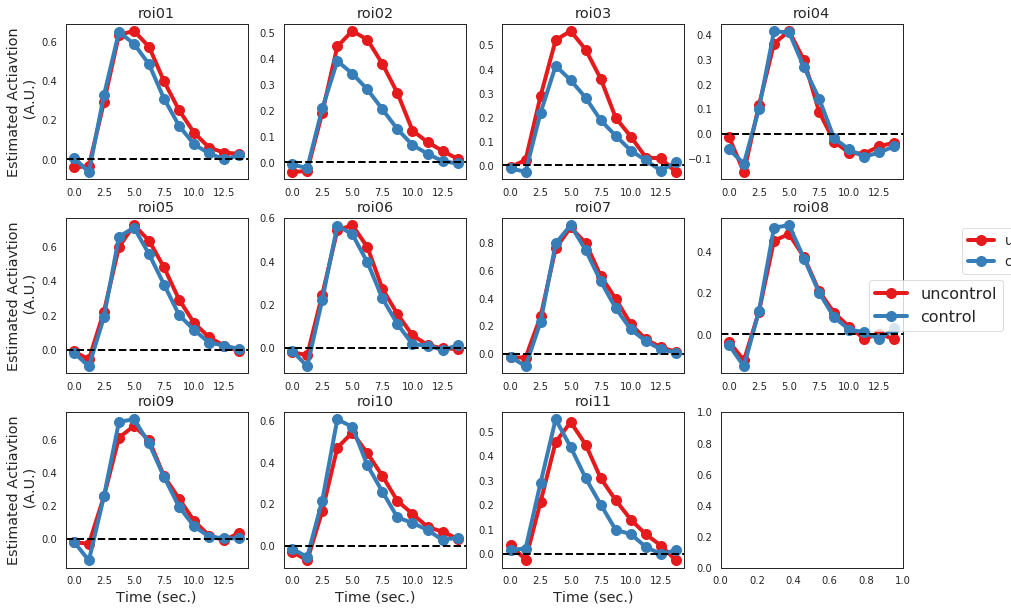

In [18]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

k_cols = 4
k_rows = 3
fig, axes = plt.subplots(nrows=k_rows, ncols=k_cols, sharey=False, figsize=(15,10))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.25,wspace=0.2)
for i,roi in enumerate(rois):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    axes[i].plot(t,uncon_mean, color=cmap.colors[0],linewidth=4,marker='o',markersize=10,label='uncontrol')

    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    
    axes[i].plot(t,con_mean, color=cmap.colors[1],linewidth=4,marker='o',markersize=10,label='control')

    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    
    if len(roi) > 24:
        title_list = roi.split()
        first_half = ' '.join(title_list[:int(len(title_list)/2)])
        second_half = ' '.join(title_list[int(len(title_list)/2):])
        title = '\n'.join([first_half,second_half])
    else:
        title = roi
    axes[i].set_title(title)
    
    if i % k_cols == 0:
        axes[i].set_ylabel('Estimated Actiavtion\n (A.U.)')
    
    if i >= k_cols*(k_rows-1):
        axes[i].set_xlabel('Time (sec.)')
    
    
    #axes[i].legend()
main_legend_handles, main_legend_labels = axes[i].get_legend_handles_labels()
fig.legend(main_legend_handles,main_legend_labels,loc='center right',fontsize=16)
plt.figlegend(main_legend_handles,main_legend_labels, loc='right',bbox_to_anchor=(1, 0.5))
#fig.savefig('figures/estimated_shock_response.png',dpi=600)